### This notebook aims to predict if and when invoices will be paid.

Understand the factors of successful collection efforts of Accounts Receivables, and predict which customers will pay fastest, thereby improving the efficiency of payment collections.

In [1]:
import math
import numpy as np
import pandas as pd
from datetime import datetime
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

#### Reading Data

In [2]:
df_receivable = pd.read_csv('./WA_Fn-UseC_-Accounts-Receivable.csv')
df_receivable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   countryCode    2466 non-null   int64  
 1   customerID     2466 non-null   object 
 2   PaperlessDate  2466 non-null   object 
 3   invoiceNumber  2466 non-null   int64  
 4   InvoiceDate    2466 non-null   object 
 5   DueDate        2466 non-null   object 
 6   InvoiceAmount  2466 non-null   float64
 7   Disputed       2466 non-null   object 
 8   SettledDate    2466 non-null   object 
 9   PaperlessBill  2466 non-null   object 
 10  DaysToSettle   2466 non-null   int64  
 11  DaysLate       2466 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 231.3+ KB


In [3]:
df_receivable.head(5)

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate
0,391,0379-NEVHP,4/6/2013,611365,1/2/2013,2/1/2013,55.94,No,1/15/2013,Paper,13,0
1,406,8976-AMJEO,3/3/2012,7900770,1/26/2013,2/25/2013,61.74,Yes,3/3/2013,Electronic,36,6
2,391,2820-XGXSB,1/26/2012,9231909,7/3/2013,8/2/2013,65.88,No,7/8/2013,Electronic,5,0
3,406,9322-YCTQO,4/6/2012,9888306,2/10/2013,3/12/2013,105.92,No,3/17/2013,Electronic,35,5
4,818,6627-ELFBK,11/26/2012,15752855,10/25/2012,11/24/2012,72.27,Yes,11/28/2012,Paper,34,4


In [4]:
df_receivable['InvoiceDate']= pd.to_datetime(df_receivable.InvoiceDate)


Generate a **Late** boolean using the variable 'DaysLate'. An invoice is considered "Late" if it is more than 7 days overdue.

In [5]:
df_receivable['Late'] = df_receivable['DaysLate'].apply(lambda x: 1 if x > 7 else 0)
df_receivable.head(3)

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate,Late
0,391,0379-NEVHP,4/6/2013,611365,2013-01-02,2/1/2013,55.94,No,1/15/2013,Paper,13,0,0
1,406,8976-AMJEO,3/3/2012,7900770,2013-01-26,2/25/2013,61.74,Yes,3/3/2013,Electronic,36,6,0
2,391,2820-XGXSB,1/26/2012,9231909,2013-07-03,8/2/2013,65.88,No,7/8/2013,Electronic,5,0,0


**countlate** is a rolling count of the amount of late payments generated for each customer.

In [6]:
df_receivable['countlate']=df_receivable.Late.eq(1).groupby(df_receivable.customerID).apply(
    lambda x : x.cumsum().shift().fillna(0)).astype(int)

In [7]:
df_receivable.head(3)

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate,Late,countlate
0,391,0379-NEVHP,4/6/2013,611365,2013-01-02,2/1/2013,55.94,No,1/15/2013,Paper,13,0,0,0
1,406,8976-AMJEO,3/3/2012,7900770,2013-01-26,2/25/2013,61.74,Yes,3/3/2013,Electronic,36,6,0,0
2,391,2820-XGXSB,1/26/2012,9231909,2013-07-03,8/2/2013,65.88,No,7/8/2013,Electronic,5,0,0,0


In [8]:
df_receivable.describe()

,countryCode,invoiceNumber,InvoiceAmount,DaysToSettle,DaysLate,Late,countlate
count,2466.000000,2.466000e+03,2466.000000,2466.00000,2466.000000,2466.000000,2466.000000
mean,620.446067,4.978431e+09,59.895856,26.44485,3.442417,0.185726,2.259530
std,215.933610,2.884272e+09,20.435838,12.33493,6.290607,0.388964,3.710186
min,391.000000,6.113650e+05,5.260000,0.00000,0.000000,0.000000,0.000000
25%,406.000000,2.528854e+09,46.400000,18.00000,0.000000,0.000000,0.000000
50%,770.000000,4.964228e+09,60.560000,26.00000,0.000000,0.000000,1.000000
75%,818.000000,7.494512e+09,73.765000,35.00000,5.000000,0.000000,3.000000
max,897.000000,9.990244e+09,128.280000,75.00000,45.000000,1.000000,28.000000


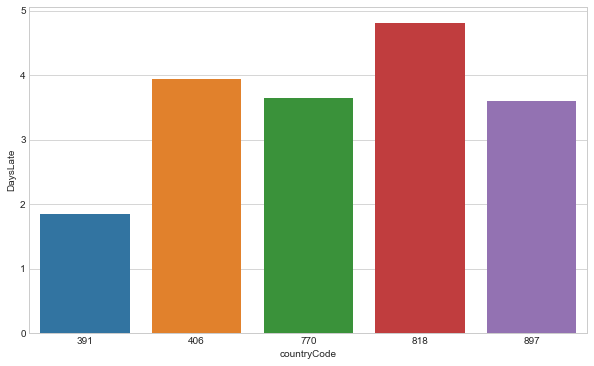

In [9]:
temp = pd.DataFrame(df_receivable.groupby(['countryCode'], axis=0)['DaysLate'].mean().reset_index())
plt.figure(figsize=(10,6))
sns.barplot(x="countryCode", y="DaysLate",data=temp)

Identified that country code 818 has maximum late days and country code 391 has minimum late days.<br>
Check the details of categorical features

In [10]:
df_receivable.describe(include=np.object)

,customerID,PaperlessDate,DueDate,Disputed,SettledDate,PaperlessBill
count,2466,2466,2466,2466,2466,2466
unique,100,91,681,2,695,2
top,9149-MATVB,3/3/2012,1/29/2013,No,4/28/2013,Paper
freq,36,58,10,1905,10,1263


Count of categorical features

In [11]:
print(pd.crosstab(index=df_receivable["countryCode"], columns="count"))
print(pd.crosstab(index=df_receivable["Late"], columns="count"))

col_0        count
countryCode       
391            616
406            561
770            506
818            387
897            396
col_0  count
Late        
0       2008
1        458


# Percentage of late payments of a customer

In [12]:
customer_late = pd.crosstab(index=df_receivable["customerID"], columns=df_receivable['Late'])
customer_late.head()

Late,0,1
customerID,,
0187-ERLSR,16,0
0379-NEVHP,26,1
0465-DTULQ,19,7
0625-TNJFG,27,1
0688-XNJRO,6,28


In [13]:
customer = "0688-XNJRO" # input customerID here

late_0 = customer_late[customer_late.index == customer][0]
late_1 = customer_late[customer_late.index == customer][1]
total = late_0 + late_1
percentage_of_late_payment = (late_1 / total) * 100

print("% of late payments \n" + percentage_of_late_payment.to_string() + "%")

% of late payments 
customerID
0688-XNJRO    82.352941%


Add a **repeatCust** variable

In [14]:
df1 = df_receivable[df_receivable['DaysLate']>0].copy()
df2 = pd.DataFrame(df1.groupby(['customerID'], axis=0, as_index=False)['DaysLate'].count())
df2.columns = (['customerID','repeatCust'])
df3 = pd.merge(df_receivable, df2, how='left', on='customerID')
df3['repeatCust'].fillna(0, inplace=True)

In [15]:
df_receivable = df3

In [16]:
def func_IA (x):
    if x>60: return "b. more than 60"
    else: return "a. less than 60"
df_receivable['InvoiceAmount_bin'] = df_receivable['InvoiceAmount'].apply(func_IA)

In [17]:
df_receivable.head(3)

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate,Late,countlate,repeatCust,InvoiceAmount_bin
0,391,0379-NEVHP,4/6/2013,611365,2013-01-02,2/1/2013,55.94,No,1/15/2013,Paper,13,0,0,0,1.0,a. less than 60
1,406,8976-AMJEO,3/3/2012,7900770,2013-01-26,2/25/2013,61.74,Yes,3/3/2013,Electronic,36,6,0,0,5.0,b. more than 60
2,391,2820-XGXSB,1/26/2012,9231909,2013-07-03,8/2/2013,65.88,No,7/8/2013,Electronic,5,0,0,0,0.0,b. more than 60


In [18]:
temp = pd.DataFrame(df_receivable.groupby(['InvoiceAmount_bin'], axis=0, as_index=False)['DaysLate'].mean())

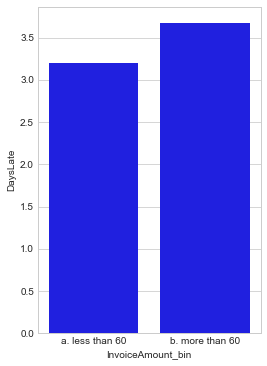

In [19]:
plt.figure(figsize=(4,6))
sns.barplot(x="InvoiceAmount_bin", y="DaysLate",data=temp,color='blue')

**Generate more features and map some of the categorical variables to integers**<br>
Map some of the categorical variables to integers. Generate more insights about a customer with the given data. 

Eg. Is a company more likely to pay on time if the order occurs at the end of the year? For that we use the **InvoiceQuarter** variable to look at the time that the invoice was made.

In [20]:
df_receivable['Disputed'] = df_receivable['Disputed'].map({'No':0,'Yes':1})
df_receivable['PaperlessBill'] = df_receivable['PaperlessBill'].map({'Paper': 0,'Electronic': 1})

In [21]:
df_receivable['InvoiceQuarter']= pd.to_datetime(df_receivable['InvoiceDate']).dt.quarter

In [22]:
df_receivable.head(3)

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate,Late,countlate,repeatCust,InvoiceAmount_bin,InvoiceQuarter
0,391,0379-NEVHP,4/6/2013,611365,2013-01-02,2/1/2013,55.94,0,1/15/2013,0,13,0,0,0,1.0,a. less than 60,1
1,406,8976-AMJEO,3/3/2012,7900770,2013-01-26,2/25/2013,61.74,1,3/3/2013,1,36,6,0,0,5.0,b. more than 60,1
2,391,2820-XGXSB,1/26/2012,9231909,2013-07-03,8/2/2013,65.88,0,7/8/2013,1,5,0,0,0,0.0,b. more than 60,3


### Relations of "Late" to other variables

Text(0.5, 1.0, 'Late payments per country code')

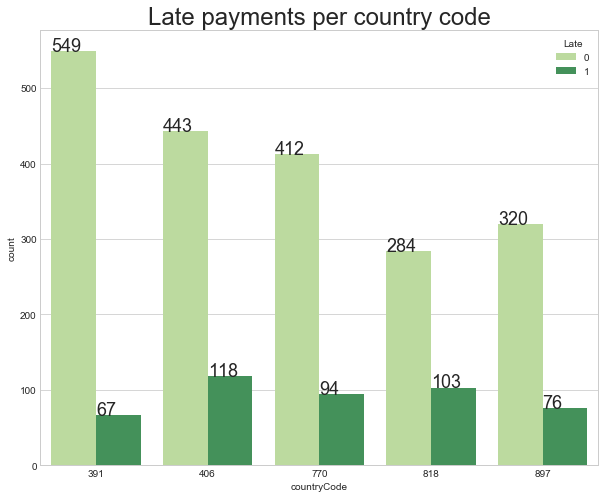

In [23]:
plt.figure(figsize=(10,8))
ax = sns.countplot(df_receivable['countryCode'],hue=df_receivable['Late'],palette="YlGn")

for p in ax.patches:
    txt = str((p.get_height()).round(1))
    txt_x = p.get_x()
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt, fontSize=18)
    
ax.set_title("Late payments per country code",fontsize=24)

Text(0.5, 1.0, 'Late payments per invoice quarter')

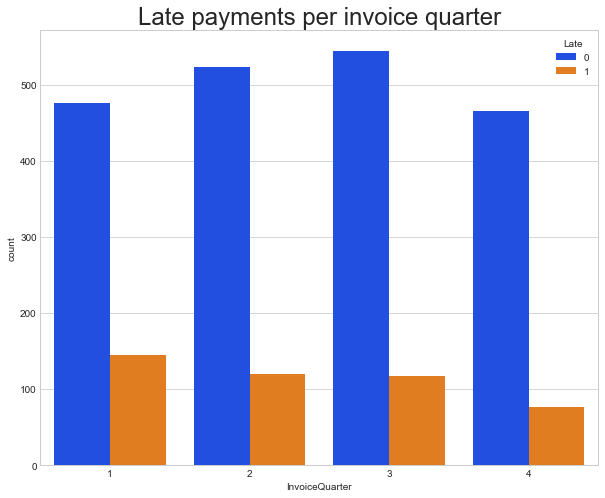

In [24]:
plt.figure(figsize=(10,8))
ax2 = sns.countplot(df_receivable['InvoiceQuarter'],hue=df_receivable['Late'],palette='bright')
ax2.set_title("Late payments per invoice quarter",fontsize=24)

### Distributions of Invoice Amounts and Days to settle
This can be helpful if we wish to know within reasonable assumptions what our confidence intervals are for payments or how long it takes for a customer to settle.

Text(0.5, 1.0, 'Invoice Amount')

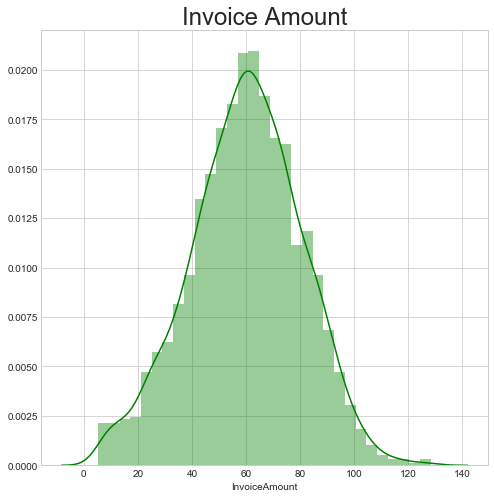

In [25]:
plt.figure(figsize=(8,8))
invoice_plot = sns.distplot(df_receivable['InvoiceAmount'],color='green')
invoice_plot.axes.set_title("Invoice Amount",fontsize=24)

Text(0.5, 1.0, 'Days to Settle')

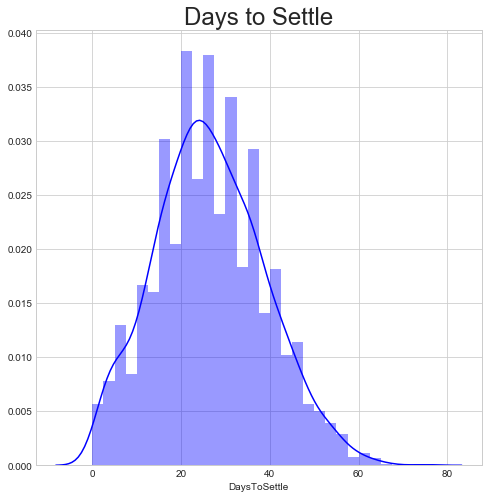

In [26]:
plt.figure(figsize=(8,8))
settle_plot = sns.distplot(df_receivable['DaysToSettle'],color='blue')
settle_plot.axes.set_title("Days to Settle",fontsize=24)

Finally, label customers with integers for processing in the model.

In [27]:
labels = df_receivable['customerID'].astype('category').cat.categories.tolist()

In [28]:
replace_map_comp = {'customerID' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

In [29]:
# replace the customerID with Integers
df_receivable.replace(replace_map_comp, inplace=True)

In [30]:
df_receivable.head(3)

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate,Late,countlate,repeatCust,InvoiceAmount_bin,InvoiceQuarter
0,391,2,4/6/2013,611365,2013-01-02,2/1/2013,55.94,0,1/15/2013,0,13,0,0,0,1.0,a. less than 60,1
1,406,83,3/3/2012,7900770,2013-01-26,2/25/2013,61.74,1,3/3/2013,1,36,6,0,0,5.0,b. more than 60,1
2,391,21,1/26/2012,9231909,2013-07-03,8/2/2013,65.88,0,7/8/2013,1,5,0,0,0,0.0,b. more than 60,3


## Train models to predict if a payment will be late

### Models used:
- Linear regression
- Gradient Boosting Regressor (best performing)
- Random Forest Regressor

In [31]:
df_receivable.head(3)

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate,Late,countlate,repeatCust,InvoiceAmount_bin,InvoiceQuarter
0,391,2,4/6/2013,611365,2013-01-02,2/1/2013,55.94,0,1/15/2013,0,13,0,0,0,1.0,a. less than 60,1
1,406,83,3/3/2012,7900770,2013-01-26,2/25/2013,61.74,1,3/3/2013,1,36,6,0,0,5.0,b. more than 60,1
2,391,21,1/26/2012,9231909,2013-07-03,8/2/2013,65.88,0,7/8/2013,1,5,0,0,0,0.0,b. more than 60,3


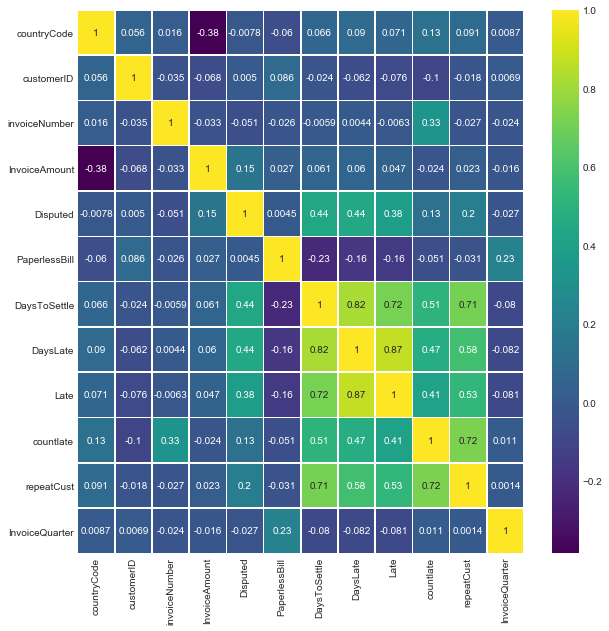

In [32]:
corremat = df_receivable.corr()
plt.figure(figsize=(10,10))
g = sns.heatmap(df_receivable.corr(),annot=True,cmap='viridis',linewidths=.5)

In [33]:
corremat.columns


Index(['countryCode', 'customerID', 'invoiceNumber', 'InvoiceAmount',
       'Disputed', 'PaperlessBill', 'DaysToSettle', 'DaysLate', 'Late',
       'countlate', 'repeatCust', 'InvoiceQuarter'],
      dtype='object')

In [34]:
cat_feats = ['InvoiceAmount_bin']
final_data = pd.get_dummies(df_receivable,columns=cat_feats,drop_first=True)

In [35]:
final_data.head(10)

,countryCode,customerID,PaperlessDate,invoiceNumber,InvoiceDate,DueDate,InvoiceAmount,Disputed,SettledDate,PaperlessBill,DaysToSettle,DaysLate,Late,countlate,repeatCust,InvoiceQuarter,InvoiceAmount_bin_b. more than 60
0,391,2,4/6/2013,611365,2013-01-02,2/1/2013,55.94,0,1/15/2013,0,13,0,0,0,1.0,1,0
1,406,83,3/3/2012,7900770,2013-01-26,2/25/2013,61.74,1,3/3/2013,1,36,6,0,0,5.0,1,1
2,391,21,1/26/2012,9231909,2013-07-03,8/2/2013,65.88,0,7/8/2013,1,5,0,0,0,0.0,3,1
3,406,92,4/6/2012,9888306,2013-02-10,3/12/2013,105.92,0,3/17/2013,1,35,5,0,0,17.0,1,1
4,818,55,11/26/2012,15752855,2012-10-25,11/24/2012,72.27,1,11/28/2012,0,34,4,0,0,9.0,4,1
5,818,37,8/28/2013,18104516,2012-01-27,2/26/2012,94.00,1,2/22/2012,0,26,0,0,0,13.0,1,1
6,897,79,12/5/2012,23864272,2013-08-13,9/12/2013,74.69,0,9/9/2013,1,27,0,0,0,26.0,3,1
7,770,33,6/27/2013,27545037,2012-12-16,1/15/2013,75.06,0,1/12/2013,0,27,0,0,0,25.0,4,1
8,770,30,3/8/2013,28049695,2012-05-14,6/13/2012,80.07,1,7/1/2012,0,48,18,1,0,19.0,2,1
9,897,68,4/4/2012,32277701,2013-07-01,7/31/2013,48.33,0,7/26/2013,1,25,0,0,0,5.0,3,0


In [36]:
features=['countryCode', 'customerID', 'InvoiceAmount', 'Late', 'DaysToSettle', 'countlate']

In [37]:
features

['countryCode',
 'customerID',
 'InvoiceAmount',
 'Late',
 'DaysToSettle',
 'countlate']

In [38]:
X = final_data[features]
y = final_data['DaysLate']

In [39]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=4) # default test size = 0.25

In [40]:
linear = LinearRegression()
linear.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
# linear Regression

y_pred1 = linear.predict(X_test)

In [42]:
#Checking the accuracy
linear_accuracy = round(linear.score(X_test,y_test)*100,2)
print(round(linear_accuracy,2),'%')

83.94 %


In [43]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test,y_pred1)

6.168253465638025

In [44]:
GBR_model = GradientBoostingRegressor(n_estimators=50, max_depth=4, random_state=4)

In [45]:
# Fit model
GBR_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=4, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [46]:
y_pred2 = GBR_model.predict(X_test)

In [47]:
# Checking the accuracy
GBR_model_accuracy = GBR_model.score(X_test,y_test)*100
print(round(GBR_model_accuracy,2),'%')

100.0 %


In [48]:
mean_squared_error(y_test,y_pred2)

0.0010551299035756417

In [49]:
random_model = RandomForestRegressor(n_estimators=100)

In [50]:
# Fit
random_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [51]:
y_pred3 = random_model.predict(X_test)

In [52]:
# Checking the accuracy
random_model_accuracy = round(random_model.score(X_test,y_test)*100,2)
print(round(random_model_accuracy,2),'%')

99.99 %


In [53]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test,y_pred3)

0.0035160453808752105

# Predicted late payments (from all customers)

### In future, can narrow to payments from individual customers as data now is too little

GBR model has the highest accuracy.

## Mean days late

/Users/rgs/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
/Users/rgs/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


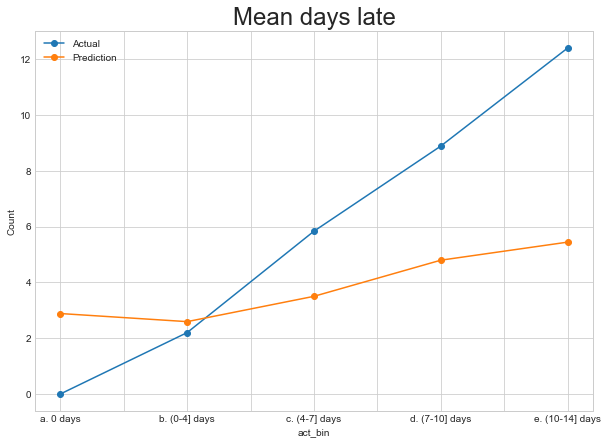

In [54]:
y = pd.concat([y_test,pd.DataFrame(y_pred2)],axis=1) # Using GBR model
y.columns = ('Actual','Prediction')

def act_decile (x):
    if x == 0: return "a. 0 days"
    elif x <= 4: return "b. (0-4] days"
    elif x <= 7: return "c. (4-7] days"
    elif x <= 10: return "d. (7-10] days"
    elif x <= 14: return "e. (10-14] days"
#     else: return "f. > 14 days"
y['act_bin'] = y['Actual'].apply(act_decile)

temp = pd.DataFrame(y.groupby(['act_bin'], axis=0, as_index=False)['Actual','Prediction'].mean())
temp.index = temp['act_bin']
tempgraph = temp.plot(marker='o',figsize=(10,7))
tempgraph.set_title("Mean days late",fontsize=24)
tempgraph.set_ylabel("Count")
tempgraph

## Payment Count

/Users/rgs/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


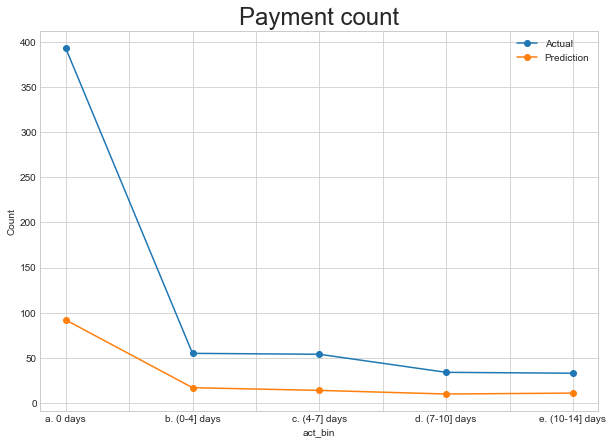

In [55]:
temp1 = pd.DataFrame(y.groupby('act_bin', axis=0)['Actual','Prediction'].count())
temp1.index = temp['act_bin']
tempgraph1 = temp1.plot(marker='o',figsize=(10,7))
tempgraph1.set_title("Payment count", fontSize=24)
tempgraph1.set_ylabel("Count")
tempgraph1

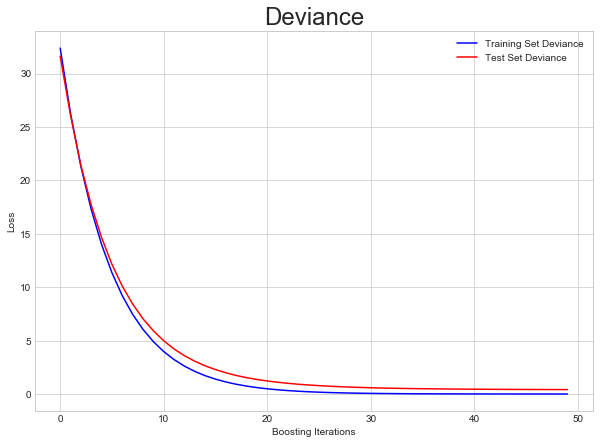

In [56]:
params = {"n_estimators":50, "max_depth":4, "random_state":4}

test_score = np.zeros(params['n_estimators'], dtype=np.float64)
for i, y_pred in enumerate(GBR_model.staged_predict(X_test - 1)):
    test_score[i] = GBR_model.loss_(y_test, y_pred)

fig = plt.figure(figsize=(10, 7))
plt.subplot(1, 1, 1)
plt.title('Deviance', fontSize = 24)
plt.plot(np.arange(params['n_estimators']), GBR_model.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']), test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')
plt.savefig("output/deviance.png")
plt.show()